In [22]:
import pandas as pd
import numpy as np
import os.path
import glob
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cross_validation import train_test_split
from sklearn.metrics import f1_score
import seaborn as sns

In [23]:
df=pd.read_csv('bagofwords.csv')
df.head()


,webpageID,labels,ac,accepting,access,accessories,accidental,account,adapter,add,...,hardware,hd,hdd,hdmi,height,help,high,home,hot,hours
0,000003_,all-products,0,0,0,3,0,1,0,0,...,0,0,0,0,0,3,0,0,0,0
1,000004_,desktops,0,0,2,0,0,1,0,0,...,0,1,0,0,0,0,1,6,0,1
2,000005_,document_,0,0,6,0,0,5,0,0,...,0,0,0,0,0,6,0,0,0,0
3,000006_,laptops,0,0,0,0,0,1,0,0,...,0,3,0,0,0,1,2,6,0,1
4,000007_,enterprise-products,0,0,0,0,0,1,0,0,...,1,0,0,0,0,2,1,0,0,0


In [24]:
X=df.iloc[:,2:]
labels=df.loc[:,'labels'].values
le=LabelEncoder()
y=le.fit_transform(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

dictlabels=dict(zip(y,labels))
print(dictlabels)
print(X_train.shape)

{0: 'all-products', 1: 'cloud-client-computing', 2: 'deals', 3: 'dell-tablets', 4: 'desktops', 5: 'document_', 6: 'enterprise-products', 7: 'laptops', 8: 'other-product', 9: 'server-storage-solutions', 10: 'software', 11: 'unkowntype_'}
(7583, 200)


In [18]:
scores=[]
scores_std=[]
N_trees=[5,10,20,30,40,50,100,150,200]
for n_tree in N_trees:
    randomforest=RandomForestClassifier(n_estimators=n_tree,n_jobs=-1)
    score=cross_val_score(estimator=randomforest,X=X_train,y=y_train,cv=10,n_jobs=-1)
    scores.append(np.mean(score))
    scores_std.append(np.std(score))

[ 0.97244518  0.97955453  0.98219817  0.98114257  0.98299567  0.98352354
  0.98246742  0.98273354  0.98352477]


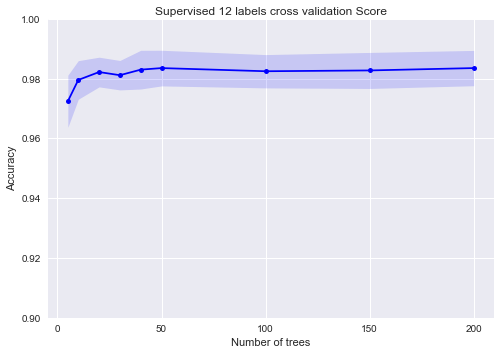

In [25]:
scores=np.array(scores)
print(scores)
scores_std=np.array(scores_std)
plt.plot(N_trees,scores,color='blue',marker='o',markersize='5')
plt.fill_between(N_trees,scores+scores_std,scores-scores_std,alpha=0.15,color='blue')
plt.xlabel('Number of trees')
plt.ylabel('Accuracy')
plt.ylim([0.9,1.0])
plt.title('Supervised 12 labels cross validation Score')
plt.show()


In [20]:
randomforest.fit(X_train,y_train)
importances = randomforest.feature_importances_
indices=np.argsort(importances)[::-1]
y_pred=randomforest.predict(X_test)

f1score=f1_score(y_test,y_pred, average=None)

print(f1score)
words_count=np.sum(X_train,axis=0)

[ 0.98659517  1.          1.          0.92        0.99167438  0.99500832
  0.98033503  0.9908953   0.90688259  0.95238095  0.95808383  0.97972973]


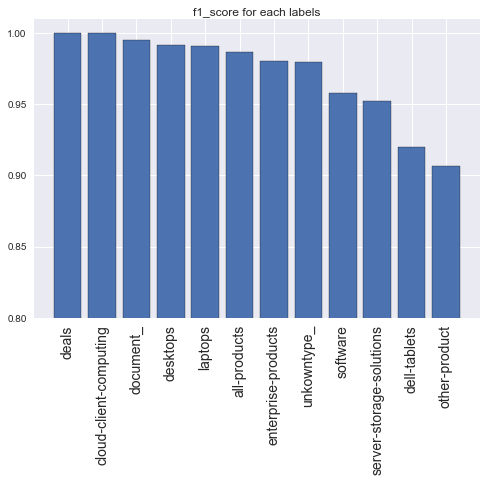

In [26]:
indices_f1=np.argsort(f1score)[::-1]
plt.bar(range(12),f1score[indices_f1],align='center')
plt.xticks(range(12),[dictlabels[i] for i in indices_f1],rotation=90, fontsize=14)
plt.ylim(0.8,1.01)
plt.title('f1_score for each labels')
plt.show()

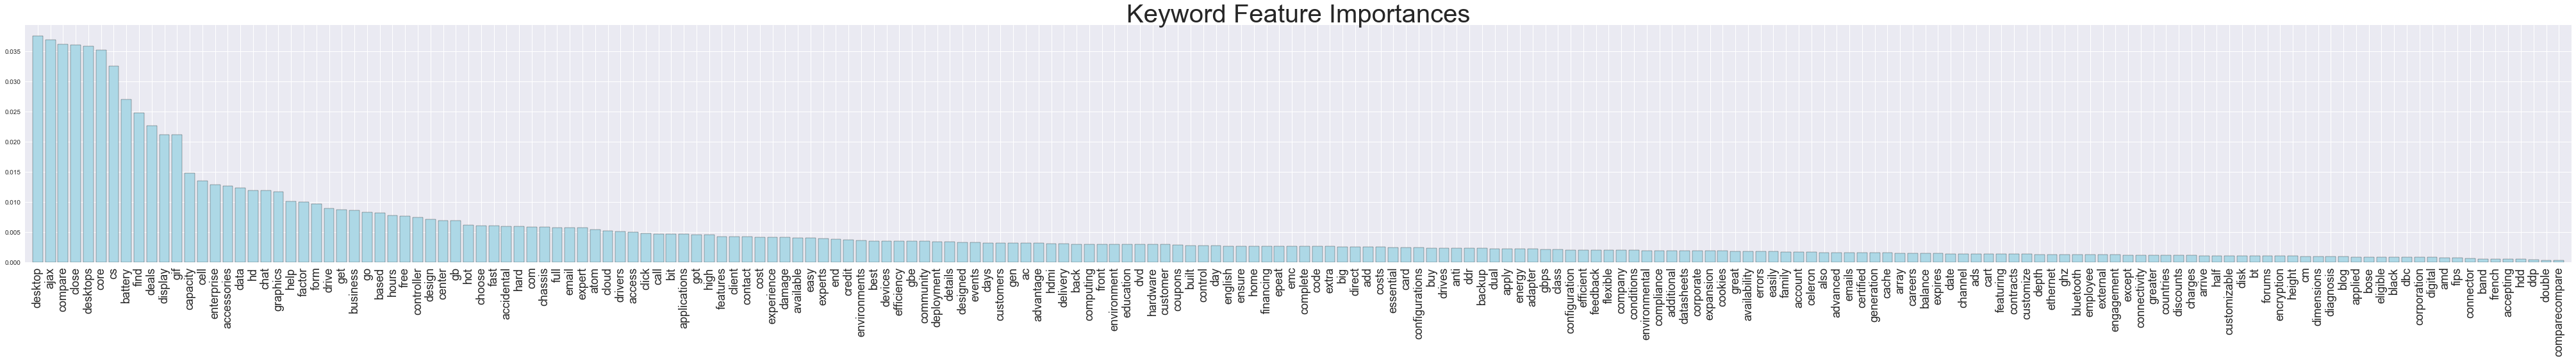

In [27]:
fig=plt.figure(figsize=(56,8))
tmp=200
plt.title('Keyword Feature Importances', fontsize = 40)
plt.bar(range(len(df.columns[2:][:tmp])),importances[indices][:tmp],color='lightblue',align='center')
plt.xticks(range(len(df.columns[2:][:tmp])),np.array(df.columns[2:])[indices][:tmp],rotation=90,fontsize=18)
plt.tight_layout()
plt.xlim(-1,tmp)
plt.show()


In [30]:
words_median = np.median(df.iloc[:,2:]+2,axis=0).astype(float)
#words_median[words_median==0]=0.01

words_mean = np.mean(df.iloc[:,2:]+2,axis=0)
median_over_mean = words_median/words_mean

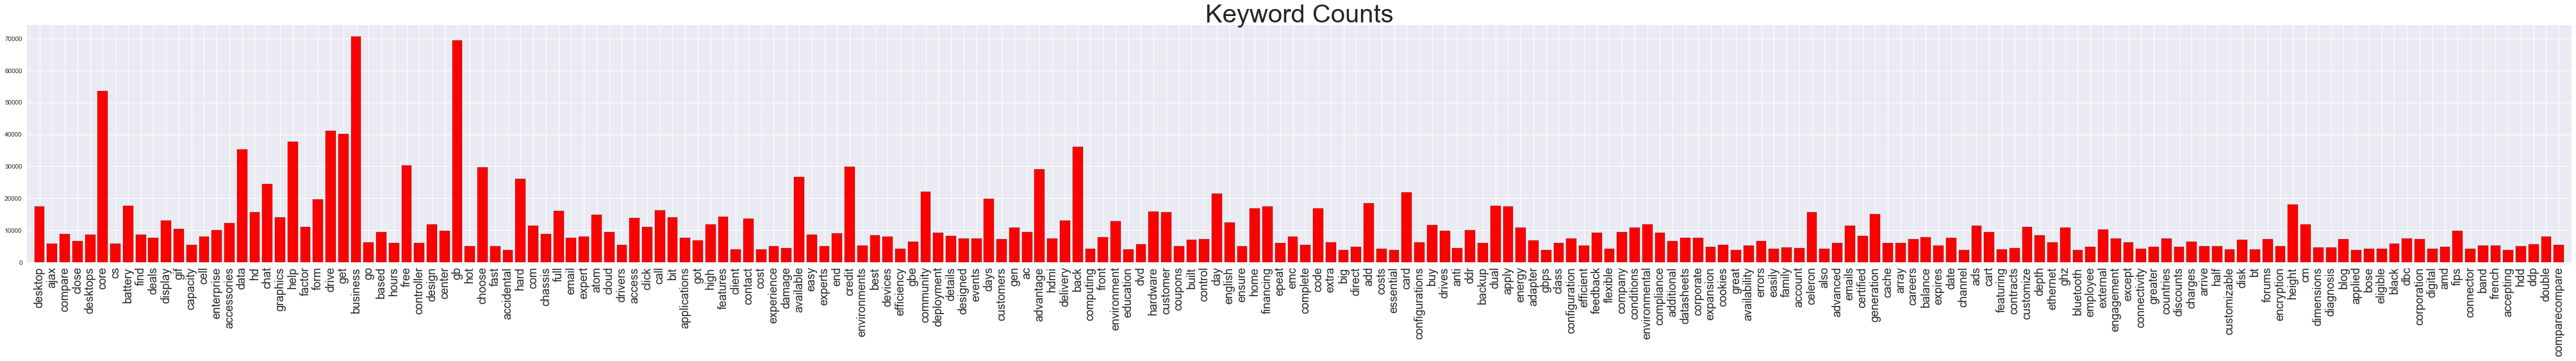

In [28]:
fig=plt.figure(figsize=(56,8))
plt.title('Keyword Counts', fontsize = 40)
plt.bar(range(len(df.columns[2:][:tmp])),words_count[indices][:tmp],color='red',align='center')
plt.xticks(range(len(df.columns[2:][:tmp])),np.array(df.columns[2:])[indices][:tmp],rotation=90,fontsize=18)
plt.tight_layout()
plt.xlim(-1,tmp)
plt.show()


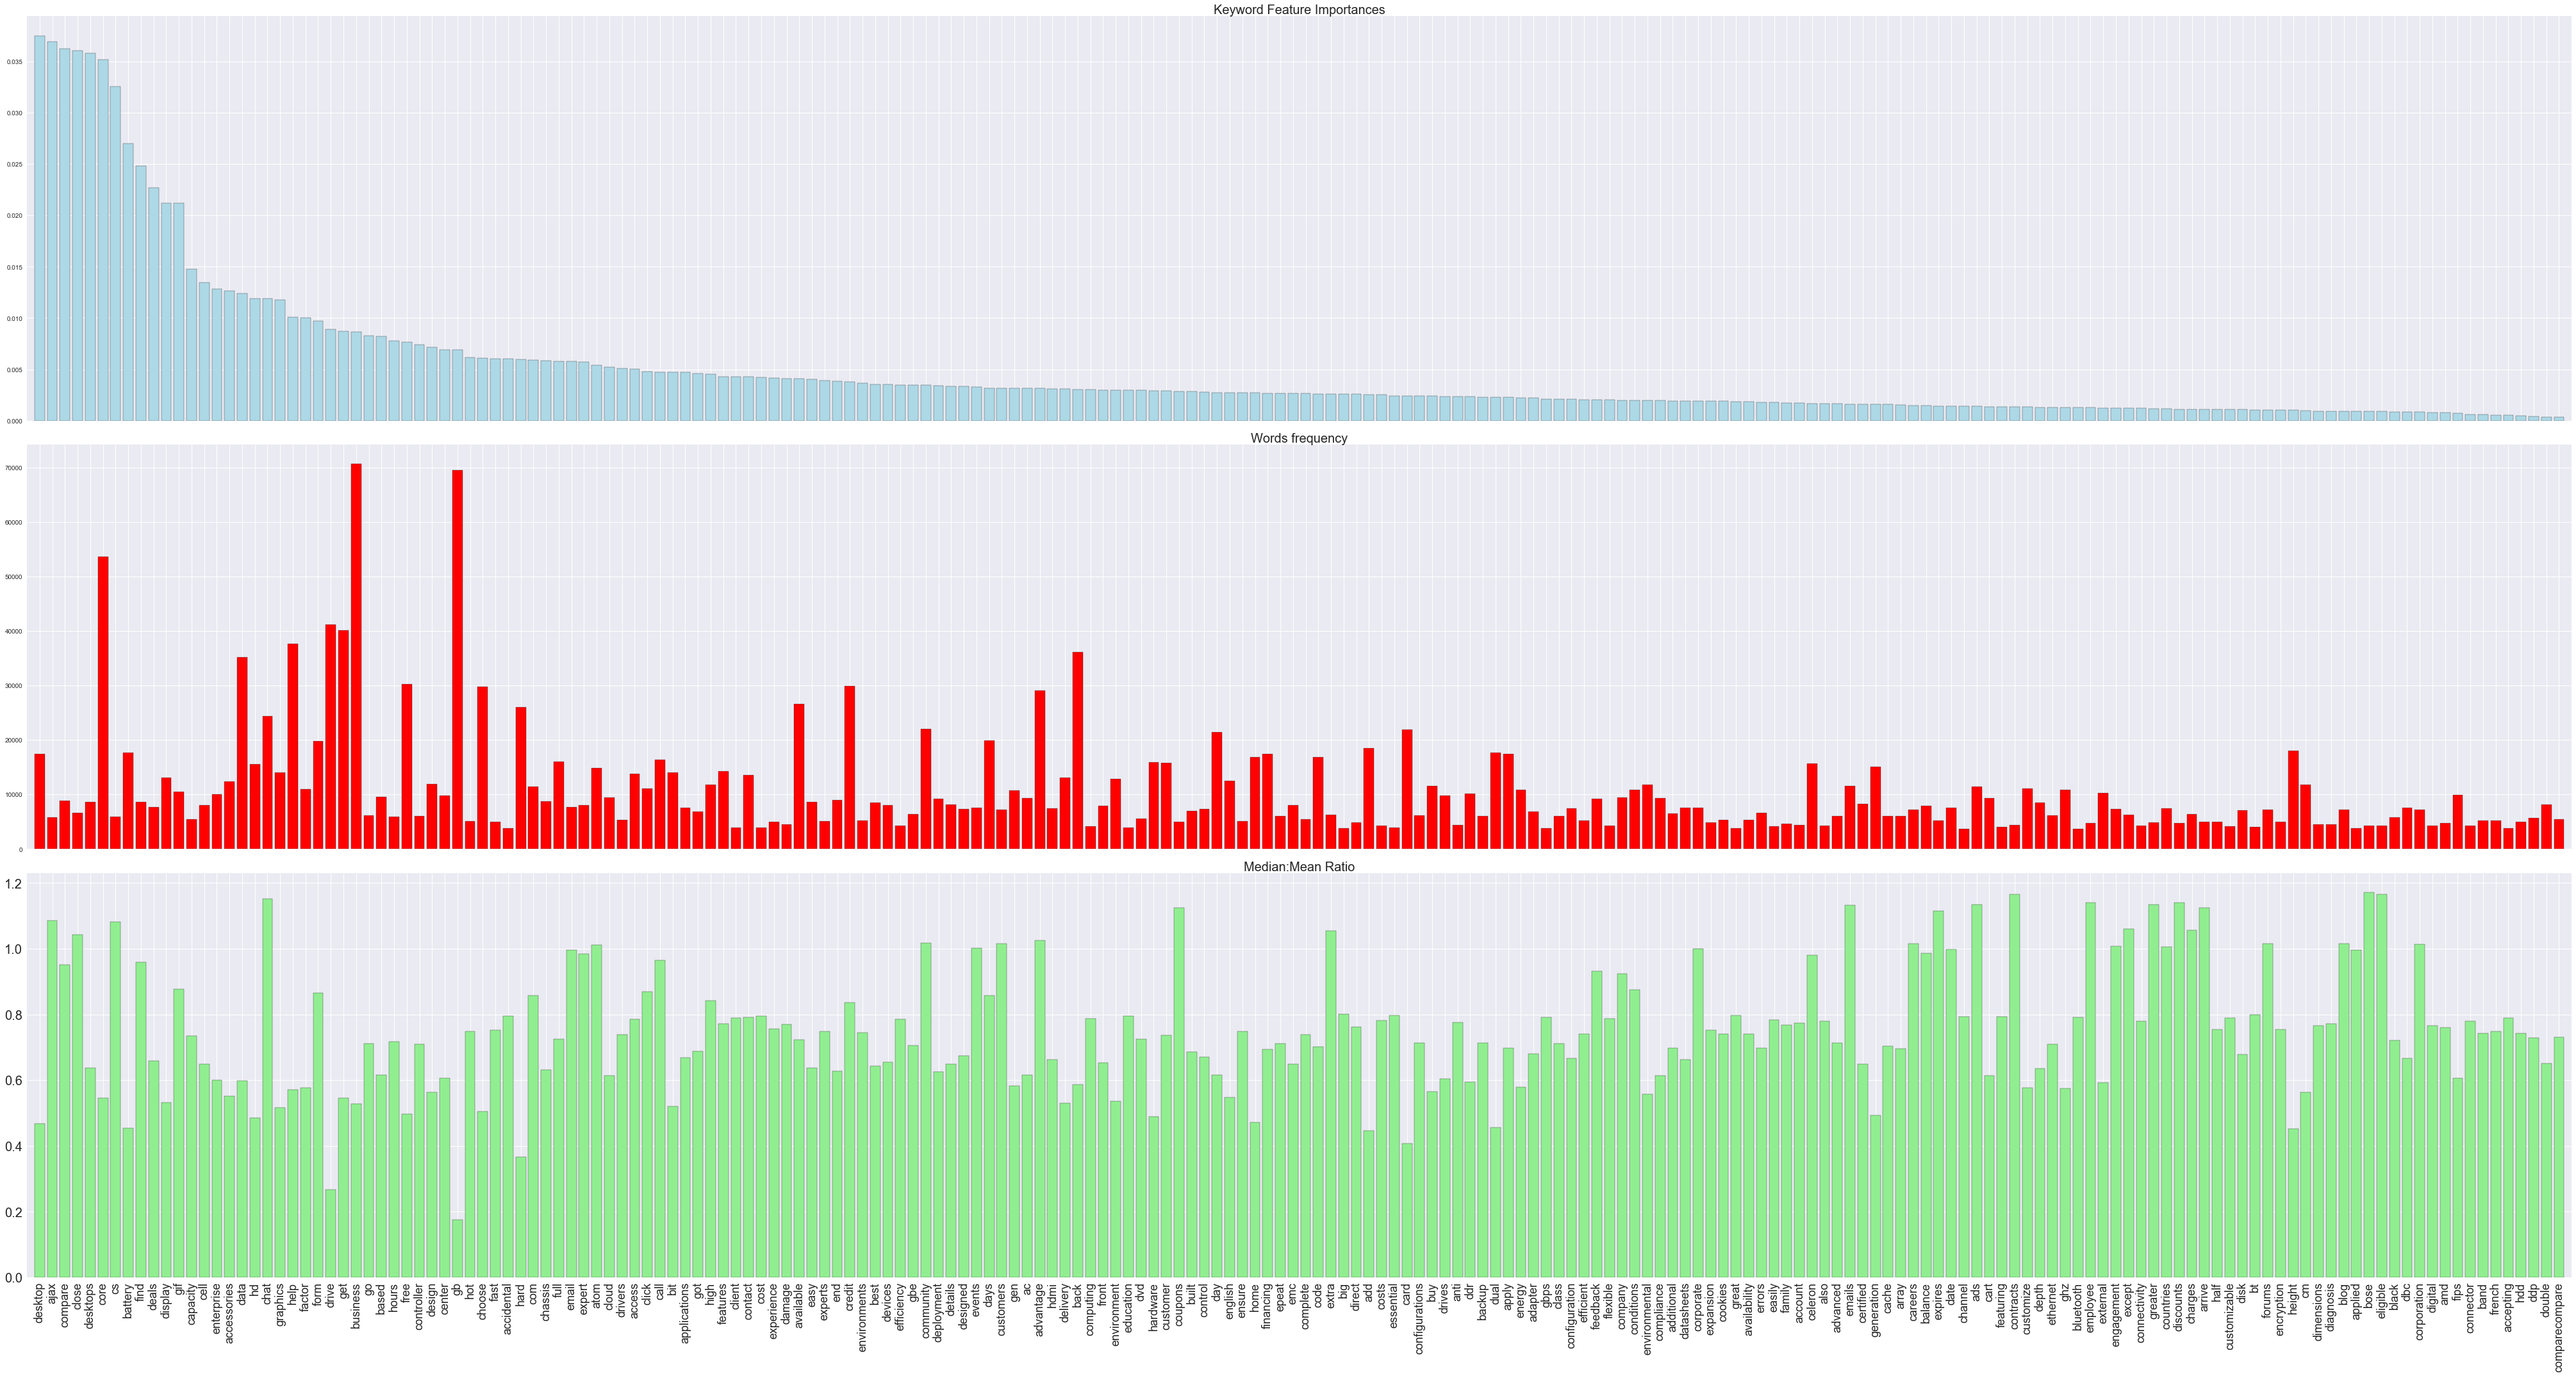

In [31]:
fig, ax = plt.subplots(nrows=3,ncols=1, figsize=(56,30),sharex=True)
ax[0].bar(range(len(df.columns[2:][:tmp])),importances[indices][:tmp],color='lightblue',align='center')
ax[0].set_title('Keyword Feature Importances', fontsize=20)
ax[1].bar(range(len(df.columns[2:][:tmp])),words_count[indices][:tmp],color='red',align='center')
ax[1].set_title('Words frequency', fontsize=20)
ax[2].set_title('Median:Mean Ratio',fontsize=20)
ax[2].bar(range(len(df.columns[2:][:tmp])),median_over_mean[indices][:tmp],color='lightgreen',align='center')
plt.xticks(range(len(df.columns[2:][:tmp])),np.array(df.columns[2:])[indices][:tmp],rotation=90,fontsize=18)
plt.tight_layout()
plt.xlim(-1,tmp)
plt.yticks(fontsize=20)

plt.show()

In [ ]:
def plot_cumulative_distribution(dataframe, keyword):
    wordfrequency,infilerequency=np.unique(dataframe.loc[:,keyword].values,return_counts=True)
    fig=plt.figure(figsize=(12,8))
    plt.bar(wordfrequency,infilerequency,align='center')
    plt.yscale('log')
    plt.xlabel('Frequency')
    plt.ylabel('Number of websites')
    plt.title('Key word : {}'.format(keyword))
    plt.show()
    fig.savefig('hendrik/veryimportant/{}.png'.format(keyword))

In [ ]:
for i in indices[:20]:
    plot_cumulative_distribution(df,df.columns[2:][i])

In [ ]:
words_median = np.median(df.iloc[:,2:]+2,axis=0).astype(float)
#words_median[words_median==0]=0.01

words_mean = np.mean(df.iloc[:,2:]+2,axis=0)
median_over_mean = words_median/words_mean

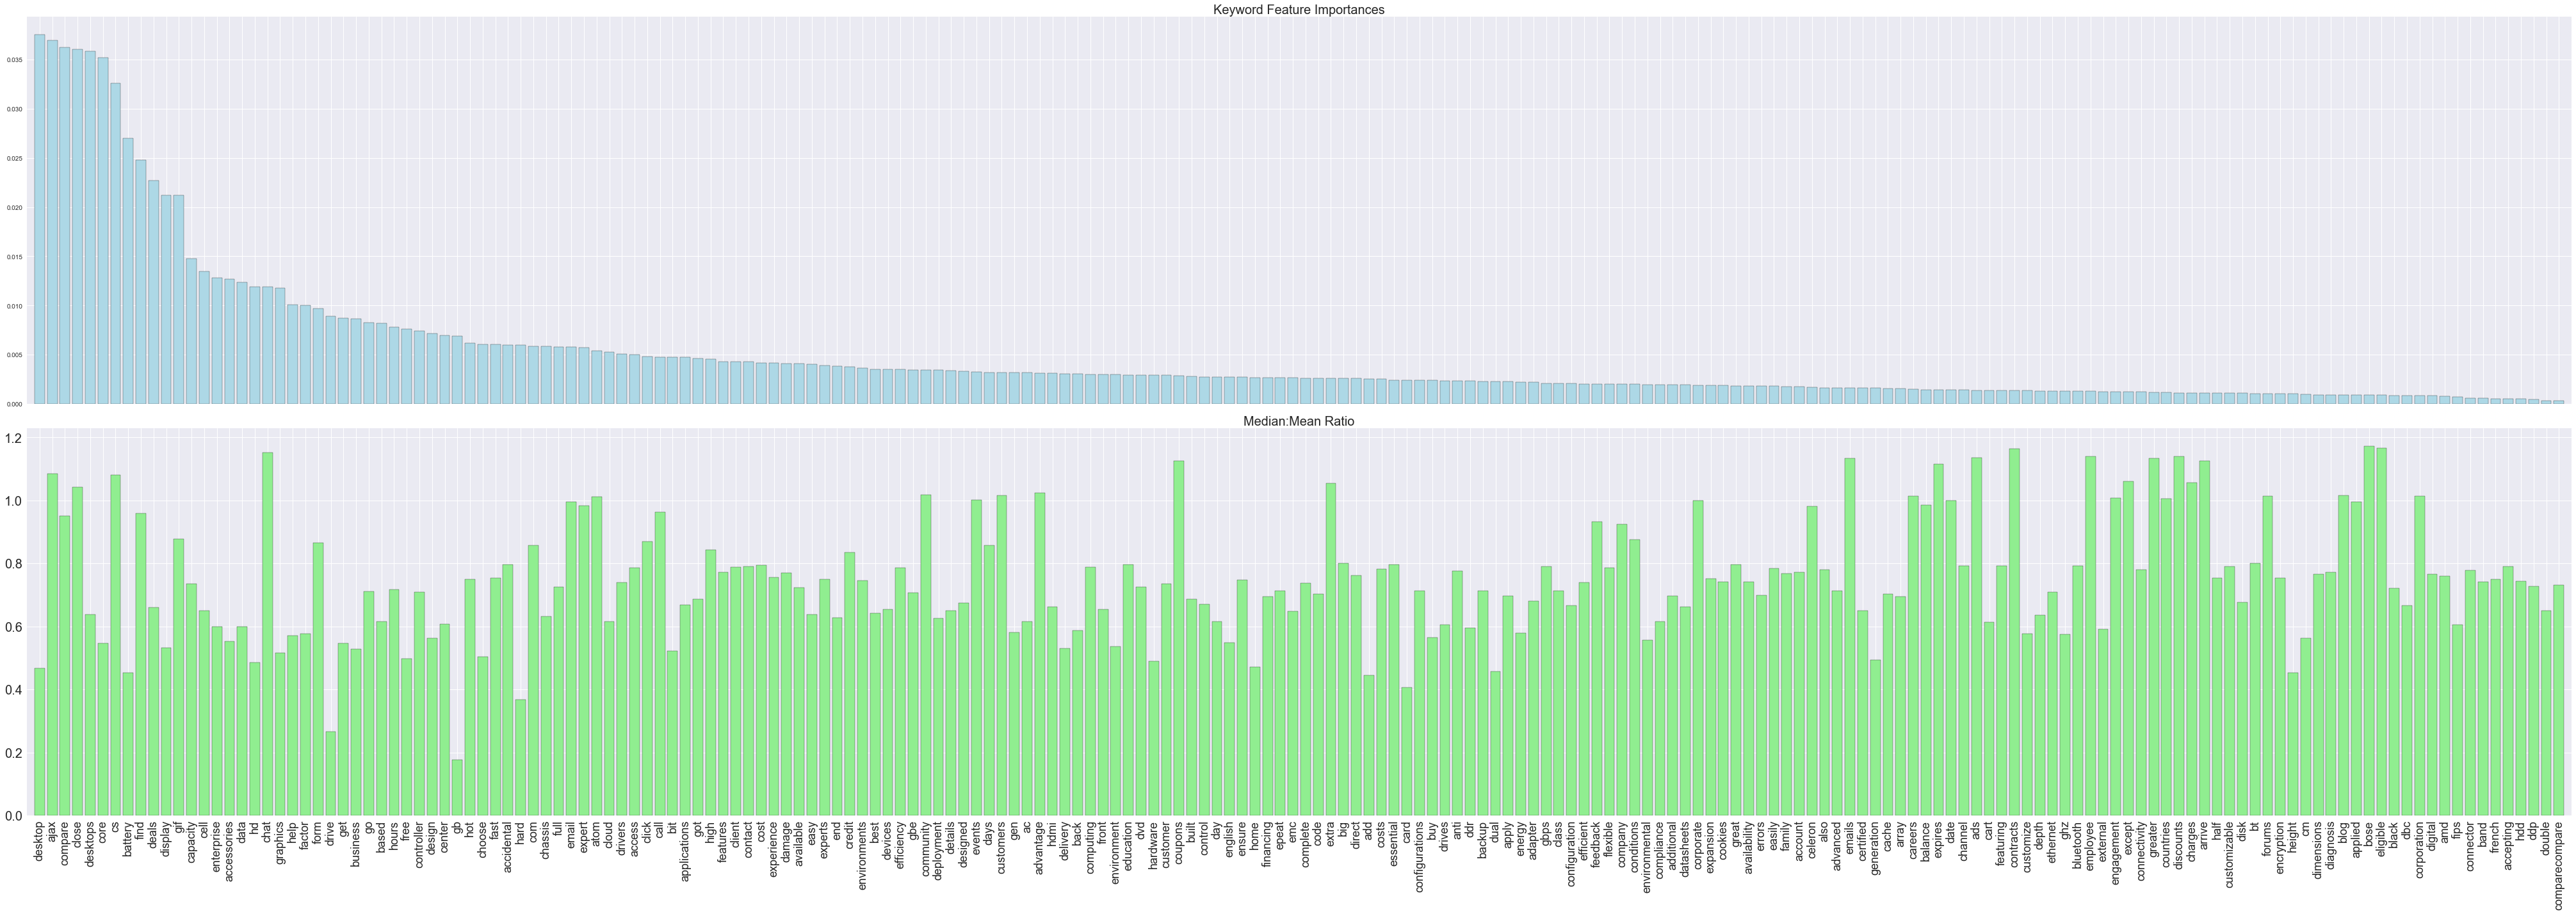

In [32]:
fig, ax = plt.subplots(nrows=2,ncols=1, figsize=(56,20),sharex=True)
ax[0].bar(range(len(df.columns[2:][:tmp])),importances[indices][:tmp],color='lightblue',align='center')
ax[0].set_title('Keyword Feature Importances', fontsize=20)
ax[1].set_title('Median:Mean Ratio',fontsize=20)
ax[1].bar(range(len(df.columns[2:][:tmp])),median_over_mean[indices][:tmp],color='lightgreen',align='center')
plt.xticks(range(len(df.columns[2:][:tmp])),np.array(df.columns[2:])[indices][:tmp],rotation=90,fontsize=18)
plt.tight_layout()
plt.xlim(-1,tmp)
plt.yticks(fontsize=20)

plt.show()